## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
import os
import cv2
import shutil
from glob import glob
from pathlib import Path
import random
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint


SEED = 42

# Python & NumPy
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# cuDNN convolution (optional but recommended)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Enable dynamic GPU memory growth (avoids pre-allocating all VRAM)
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6800)]  # MB
    )
    tf.config.experimental.set_visible_devices(gpus[0], "GPU")


# Functions

## F1 score function (from notebook 7)

In [2]:
# In Keras we have built in metrics
# We can also create custom metrics, such as F1 score
# Why don't we just use accuracy?
def f1(y_true, y_pred):
    """Binary F1 metric for Keras tensors.

    Rounds/clips predictions to 0/1, computes precision and recall, then
    returns their harmonic mean (with epsilon for stability).
    """
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1))) # threshold x >= 0.5 === 1, x <= 0.5 === 0
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # threshold x >= 0.5 === 1, x <= 0.5 === 0
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def per_class_metrics(y_true, y_pred, n_classes=4, class_names=None):
    """Compute per-class precision/recall/F1/IoU and support for segmentation masks.

    y_true, y_pred: int arrays of shape (N, H, W) with values 0..n_classes-1
    """
    if class_names is None:
        class_names = [f"class_{c}" for c in range(n_classes)]
    
    metrics = {}
    
    for c in range(n_classes):
        # boolean masks for this class
        t = (y_true == c)
        p = (y_pred == c)
        
        tp = np.logical_and(t, p).sum()
        fp = np.logical_and(~t, p).sum()
        fn = np.logical_and(t, ~p).sum()
        
        precision = tp / (tp + fp + 1e-7)
        recall    = tp / (tp + fn + 1e-7)
        f1        = 2 * precision * recall / (precision + recall + 1e-7)
        
        intersection = tp
        union        = tp + fp + fn
        iou          = intersection / (union + 1e-7)
        
        metrics[class_names[c]] = {
            "precision": precision,
            "recall":    recall,
            "f1":        f1,
            "iou":       iou,
            "support":   t.sum(),  # number of gt pixels of this class
        }
    return metrics


In [3]:
# def F1_per_class(y_true, y_pred, n_classes=4):
#     f1s = []

#     for c in range(n_classes):
#         true_c = (y_true == c)
#         pred_c = (y_pred == c)

#         TP = np.logical_and(true_c, pred_c).sum()
#         FP = np.logical_and(~true_c, pred_c).sum()
#         FN = np.logical_and(true_c, ~pred_c).sum()

#         if TP + FP + FN == 0:
#             f1s.append(np.nan)
#         else:
#             f1 = 2 * TP / (2*TP + FP + FN)
#             f1s.append(f1)

#     return f1s

# f1s = F1_per_class(Y_mask, P_mask, n_classes=4)
# print("F1 per class:", f1s)


## Dice coeficient

The F1 metric applies a hard 0.5 threshold to the predicted mask, so it cannot detect small improvements while the model is still learning. The Dice coefficient uses the continuous prediction values directly, making it more sensitive to gradual improvements in segmentation performance, especially in the early training stages.

[Dice-Sørensen coefficient](https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient)

In [4]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    """Soft Dice coefficient for overlap between predicted and true masks."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


## Plot loss

In [5]:
def plot_loss(loss,val_loss):
  """Plot training and validation loss curves across epochs."""
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()


## Plot F1

In [6]:
def plot_f1(history):
    """Plot F1 score curves for train/validation across epochs."""
    plt.figure()
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('Model F1 score')
    plt.ylabel('F1 score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()


## Evaluation function

In [7]:
def eval_full_val(model, val_gen, val_steps, n_classes=4, class_names=None, predict_batch_size=None):
    if class_names is None:
        class_names = ["background", "root", "shoot", "seed"]
    tp = np.zeros(n_classes, dtype=np.int64)
    fp = np.zeros_like(tp)
    fn = np.zeros_like(tp)
    supp = np.zeros_like(tp)

    for _ in range(val_steps):
        Xb, Yb = next(val_gen)
        pred = model.predict(Xb, batch_size=predict_batch_size)
        yp = np.argmax(pred, axis=-1)
        yt = np.argmax(Yb, axis=-1)
        for c in range(n_classes):
            t = (yt == c)
            p = (yp == c)
            tp[c] += np.logical_and(t, p).sum()
            fp[c] += np.logical_and(~t, p).sum()
            fn[c] += np.logical_and(t, ~p).sum()
            supp[c] += t.sum()

    metrics = {}
    for c, name in enumerate(class_names):
        if tp[c] + fp[c] == 0 and tp[c] + fn[c] == 0:
            precision = recall = f1 = iou = 0.0
        else:
            precision = tp[c] / (tp[c] + fp[c] + 1e-7)
            recall    = tp[c] / (tp[c] + fn[c] + 1e-7)
            f1        = 2 * precision * recall / (precision + recall + 1e-7)
            iou       = tp[c] / (tp[c] + fp[c] + fn[c] + 1e-7)
        metrics[name] = {
            "precision": precision,
            "recall":    recall,
            "f1":        f1,
            "iou":       iou,
            "support":   supp[c],
        }
    return metrics

# Singleclass model

### Reducing empty masks 

In [ ]:
# Filter out empty mask patches to reduce imbalance; move excess empty patches
# to parallel removed_images/removed_masks folders, keeping at most a fraction
# of empty samples alongside non-empty ones.

patch_dir = "../Task_4/dataset_patched"

train_img_root  = os.path.join(patch_dir, "train_images")   # e.g. train_images/train/...
train_mask_root = os.path.join(patch_dir, "train_masks")    # e.g. train_masks/train/...

IMAGE_EXT = ".png"
MASK_EXT  = ".tif"

REMOVED_IMG_ROOT  = os.path.join(patch_dir, "removed_images")
REMOVED_MASK_ROOT = os.path.join(patch_dir, "removed_masks")
os.makedirs(REMOVED_IMG_ROOT,  exist_ok=True)
os.makedirs(REMOVED_MASK_ROOT, exist_ok=True)

mask_paths = glob(os.path.join(train_mask_root, "**","" f"*{MASK_EXT}"), recursive=True)

non_empty = []
empty = []

for mpath in mask_paths:
    mpath = Path(mpath)
    mask = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    if np.sum(mask > 0) == 0:
        empty.append(mpath)
    else:
        non_empty.append(mpath)

print("Non-empty masks:", len(non_empty))
print("Empty masks:", len(empty))

max_empty_fraction = 0.25
max_empty_to_keep  = int(max_empty_fraction * len(non_empty))

random.shuffle(empty)
keep_empty   = empty[:max_empty_to_keep]
remove_empty = empty[max_empty_to_keep:]

print(len(remove_empty), f"empty patches will be removed")

moved_masks = 0
moved_imgs  = 0

for mpath in remove_empty:
    # Example: "train_Elavendan_232430_im4_root_mask_118.tif"
    stem = mpath.stem

    if "_root_mask_" not in stem:
        print("WARNING: unexpected mask name pattern:", stem)
        continue

    core, patch_idx = stem.split("_root_mask_")  # core="train_..._im4", patch_idx="118"

    image_filename = f"{core}_{patch_idx}{IMAGE_EXT}"  # "train_..._im4_118.png"

    # preserve subfolder structure relative to train_mask_root
    rel_mask = mpath.relative_to(train_mask_root)  # e.g. "train/train_..._root_mask_118.tif"
    rel_dir  = rel_mask.parent                     # e.g. "train"
    rel_img  = rel_dir / image_filename            # e.g. "train/train_..._im4_118.png"

    ipath = Path(train_img_root, rel_img)          # full image path

    dest_mask = Path(REMOVED_MASK_ROOT, rel_mask)
    dest_img  = Path(REMOVED_IMG_ROOT,  rel_img)

    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    dest_img.parent.mkdir(parents=True, exist_ok=True)

    # move mask
    if mpath.exists():
        shutil.move(str(mpath), str(dest_mask))
        moved_masks += 1

    # move image
    if ipath.exists():
        shutil.move(str(ipath), str(dest_img))
        moved_imgs += 1
    else:
        print("WARNING: image not found for mask:", mpath.name, "expected:", ipath)

print("Moved masks:", moved_masks)
print("Moved images:", moved_imgs)


### U-net model

In [ ]:


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="unet_model_patchsize256px",

    # track hyperparameters and run metadata with wandb.config
    config={
        "loss": "binary_crossentropy",
        "optimizer": "adam",
        "metric": f1,
        "epoch": 100,
        "batch_size": 16
    }
)

# [optional] use wandb.config as your config
config = wandb.config

wandb: Currently logged in as: 243552 (243552-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
    # model.summary()
    
    return model

In [10]:
patch_size = 256

In [11]:
model = simple_unet_model(patch_size, patch_size, 3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1])
model.summary()

cb = EarlyStopping(monitor='loss',
                   patience=5,
                   restore_best_weights='True',
                   mode='min')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_unet_model_patchsize256px.h5',
                             monitor='val_f1',
                             save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

### Generator

#### Mask preprocess

In [ ]:
def mask_preprocess(x):
    """Threshold mask arrays to binary float values for data generators.

    Converts grayscale mask tensors to 0/1 by applying a 0.5 cutoff so augmentations
    keep hard labels instead of soft values.
    """
    return (x > 0.5).astype('float32')


### Traing images/masks

In [ ]:
# Training generator: pair ImageDataGenerators for images and masks with a shared
# seed and no shuffling so zipped batches stay aligned. Images are rescaled
# while masks use mask_preprocess to keep them binary/encoded.
batch_size = 16

# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator(preprocessing_function=mask_preprocess)

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)


Found 16073 images belonging to 1 classes.
Found 16073 images belonging to 1 classes.


### Validation images/masks

In [ ]:
# Validation generator built the same way as training: paired image/mask flows
# with shared seed and no shuffle to preserve alignment; images are rescaled
# and masks go through mask_preprocess.

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator(preprocessing_function=mask_preprocess)

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)


Found 2057 images belonging to 1 classes.
Found 2057 images belonging to 1 classes.


### Sanity check

Image range: 0.0 1.0
Mask range: 0.0 1.0


(-0.5, 255.5, 255.5, -0.5)

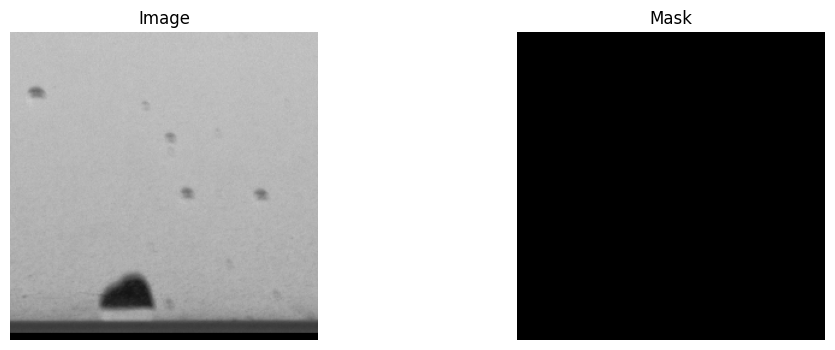

In [15]:
x_train_batch, y_train_batch = next(zip(train_image_generator, train_mask_generator))

print("Image range:", x_train_batch.min(), x_train_batch.max())
print("Mask range:", y_train_batch.min(), y_train_batch.max())

i = np.random.randint(0, x_train_batch.shape[0])

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].imshow(x_train_batch[i])
ax[0].set_title("Image"); ax[0].axis("off")

ax[1].imshow(y_train_batch[i].squeeze(), cmap='gray')
ax[1].set_title("Mask"); ax[1].axis("off")

### Train

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//config.batch_size,
    callbacks=[cb, checkpoint,
               WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models")]
)
wandb.finish()

Epoch 1/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0542 - f1: 0.3548

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 228s 217ms/step - loss: 0.0542 - f1: 0.3548 - val_loss: 0.0088 - val_f1: 0.4539
Epoch 2/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0252 - f1: 0.6077

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 205s 204ms/step - loss: 0.0252 - f1: 0.6077 - val_loss: 0.0055 - val_f1: 0.4836
Epoch 3/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0212 - f1: 0.6356

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 204ms/step - loss: 0.0212 - f1: 0.6356 - val_loss: 0.0051 - val_f1: 0.4866
Epoch 4/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0200 - f1: 0.6410

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0200 - f1: 0.6410 - val_loss: 0.0045 - val_f1: 0.4929
Epoch 5/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0193 - f1: 0.6515

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0193 - f1: 0.6515 - val_loss: 0.0040 - val_f1: 0.5070
Epoch 6/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0185 - f1: 0.6579

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0185 - f1: 0.6579 - val_loss: 0.0040 - val_f1: 0.5068
Epoch 7/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0181 - f1: 0.6631

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0181 - f1: 0.6631 - val_loss: 0.0038 - val_f1: 0.5235
Epoch 8/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0175 - f1: 0.6684

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0175 - f1: 0.6684 - val_loss: 0.0038 - val_f1: 0.5202
Epoch 9/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0171 - f1: 0.6727

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0171 - f1: 0.6727 - val_loss: 0.0036 - val_f1: 0.5169
Epoch 10/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0168 - f1: 0.6766

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0168 - f1: 0.6766 - val_loss: 0.0037 - val_f1: 0.5176
Epoch 11/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0166 - f1: 0.6786

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 205ms/step - loss: 0.0166 - f1: 0.6786 - val_loss: 0.0036 - val_f1: 0.5220
Epoch 12/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0162 - f1: 0.6819

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0162 - f1: 0.6819 - val_loss: 0.0037 - val_f1: 0.5200
Epoch 13/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0160 - f1: 0.6839

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0160 - f1: 0.6839 - val_loss: 0.0036 - val_f1: 0.5194
Epoch 14/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0159 - f1: 0.6863

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 206s 205ms/step - loss: 0.0159 - f1: 0.6863 - val_loss: 0.0036 - val_f1: 0.5278
Epoch 15/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0158 - f1: 0.6879

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0158 - f1: 0.6879 - val_loss: 0.0037 - val_f1: 0.5269
Epoch 16/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0155 - f1: 0.6894

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 205ms/step - loss: 0.0155 - f1: 0.6894 - val_loss: 0.0037 - val_f1: 0.5251
Epoch 17/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0155 - f1: 0.6903

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0155 - f1: 0.6903 - val_loss: 0.0036 - val_f1: 0.5356
Epoch 18/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0154 - f1: 0.6913

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0154 - f1: 0.6913 - val_loss: 0.0036 - val_f1: 0.5282
Epoch 19/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0152 - f1: 0.6927

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 205ms/step - loss: 0.0152 - f1: 0.6927 - val_loss: 0.0038 - val_f1: 0.5208
Epoch 20/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0151 - f1: 0.6941

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0151 - f1: 0.6941 - val_loss: 0.0035 - val_f1: 0.5296
Epoch 21/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0150 - f1: 0.6951

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 205ms/step - loss: 0.0150 - f1: 0.6951 - val_loss: 0.0036 - val_f1: 0.5233
Epoch 22/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0150 - f1: 0.6950

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0150 - f1: 0.6950 - val_loss: 0.0035 - val_f1: 0.5337
Epoch 23/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0149 - f1: 0.6965

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0149 - f1: 0.6965 - val_loss: 0.0035 - val_f1: 0.5377
Epoch 24/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0148 - f1: 0.6973

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0148 - f1: 0.6973 - val_loss: 0.0036 - val_f1: 0.5354
Epoch 25/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0148 - f1: 0.6976

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1005/1005 [==============================] - 227s 226ms/step - loss: 0.0148 - f1: 0.6976 - val_loss: 0.0035 - val_f1: 0.5395
Epoch 26/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0148 - f1: 0.6978

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0148 - f1: 0.6978 - val_loss: 0.0035 - val_f1: 0.5388
Epoch 27/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0147 - f1: 0.6987

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0147 - f1: 0.6987 - val_loss: 0.0035 - val_f1: 0.5346
Epoch 28/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0146 - f1: 0.6995

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0146 - f1: 0.6995 - val_loss: 0.0037 - val_f1: 0.5247
Epoch 29/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0146 - f1: 0.6994

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0146 - f1: 0.6994 - val_loss: 0.0033 - val_f1: 0.5356
Epoch 30/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0146 - f1: 0.6994

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0146 - f1: 0.6994 - val_loss: 0.0034 - val_f1: 0.5419
Epoch 31/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0146 - f1: 0.6995

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0146 - f1: 0.6995 - val_loss: 0.0034 - val_f1: 0.5434
Epoch 32/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0144 - f1: 0.7006

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0144 - f1: 0.7006 - val_loss: 0.0034 - val_f1: 0.5323
Epoch 33/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0144 - f1: 0.7009

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0144 - f1: 0.7009 - val_loss: 0.0033 - val_f1: 0.5377
Epoch 34/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0144 - f1: 0.7008

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0144 - f1: 0.7008 - val_loss: 0.0035 - val_f1: 0.5287
Epoch 35/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7022

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0143 - f1: 0.7022 - val_loss: 0.0033 - val_f1: 0.5379
Epoch 36/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7019

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0143 - f1: 0.7019 - val_loss: 0.0032 - val_f1: 0.5381
Epoch 37/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7023

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0143 - f1: 0.7023 - val_loss: 0.0034 - val_f1: 0.5448
Epoch 38/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7035

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0143 - f1: 0.7035 - val_loss: 0.0033 - val_f1: 0.5439
Epoch 39/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7028

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0143 - f1: 0.7028 - val_loss: 0.0034 - val_f1: 0.5418
Epoch 40/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7034

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0143 - f1: 0.7034 - val_loss: 0.0033 - val_f1: 0.5482
Epoch 41/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7037

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0142 - f1: 0.7037 - val_loss: 0.0034 - val_f1: 0.5386
Epoch 42/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7039

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0142 - f1: 0.7039 - val_loss: 0.0033 - val_f1: 0.5379
Epoch 43/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7047

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0142 - f1: 0.7047 - val_loss: 0.0033 - val_f1: 0.5367
Epoch 44/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7038

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0142 - f1: 0.7038 - val_loss: 0.0032 - val_f1: 0.5396
Epoch 45/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0141 - f1: 0.7044

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0141 - f1: 0.7044 - val_loss: 0.0032 - val_f1: 0.5416
Epoch 46/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7042

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0142 - f1: 0.7042 - val_loss: 0.0033 - val_f1: 0.5380
Epoch 47/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0141 - f1: 0.7046

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0141 - f1: 0.7046 - val_loss: 0.0034 - val_f1: 0.5369
Epoch 48/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0141 - f1: 0.7048

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0141 - f1: 0.7048 - val_loss: 0.0033 - val_f1: 0.5360
Epoch 49/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7057

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0140 - f1: 0.7057 - val_loss: 0.0032 - val_f1: 0.5444
Epoch 50/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7062

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0140 - f1: 0.7062 - val_loss: 0.0031 - val_f1: 0.5422
Epoch 51/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7060

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0140 - f1: 0.7060 - val_loss: 0.0032 - val_f1: 0.5388
Epoch 52/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7063

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0140 - f1: 0.7063 - val_loss: 0.0032 - val_f1: 0.5413
Epoch 53/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7053

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0140 - f1: 0.7053 - val_loss: 0.0032 - val_f1: 0.5369
Epoch 54/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7062

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0140 - f1: 0.7062 - val_loss: 0.0032 - val_f1: 0.5472
Epoch 55/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7055

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0140 - f1: 0.7055 - val_loss: 0.0032 - val_f1: 0.5463
Epoch 56/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7065

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0140 - f1: 0.7065 - val_loss: 0.0034 - val_f1: 0.5407
Epoch 57/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7071

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0139 - f1: 0.7071 - val_loss: 0.0033 - val_f1: 0.5398
Epoch 58/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7068

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0139 - f1: 0.7068 - val_loss: 0.0031 - val_f1: 0.5428
Epoch 59/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7074

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0139 - f1: 0.7074 - val_loss: 0.0031 - val_f1: 0.5415
Epoch 60/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7079

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0139 - f1: 0.7079 - val_loss: 0.0032 - val_f1: 0.5468
Epoch 61/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7074

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0138 - f1: 0.7074 - val_loss: 0.0033 - val_f1: 0.5443
Epoch 62/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7072

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0138 - f1: 0.7072 - val_loss: 0.0031 - val_f1: 0.5511
Epoch 63/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7068

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0139 - f1: 0.7068 - val_loss: 0.0031 - val_f1: 0.5491
Epoch 64/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7073

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0139 - f1: 0.7073 - val_loss: 0.0032 - val_f1: 0.5417
Epoch 65/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7074

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0139 - f1: 0.7074 - val_loss: 0.0032 - val_f1: 0.5365
Epoch 66/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7081

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0138 - f1: 0.7081 - val_loss: 0.0031 - val_f1: 0.5425
Epoch 67/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7092

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0138 - f1: 0.7092 - val_loss: 0.0031 - val_f1: 0.5431
Epoch 68/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7080

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


1005/1005 [==============================] - 228s 227ms/step - loss: 0.0138 - f1: 0.7080 - val_loss: 0.0032 - val_f1: 0.5484
Epoch 69/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7074

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0138 - f1: 0.7074 - val_loss: 0.0032 - val_f1: 0.5425
Epoch 70/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7074

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0138 - f1: 0.7074 - val_loss: 0.0031 - val_f1: 0.5435
Epoch 71/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7083

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0138 - f1: 0.7083 - val_loss: 0.0031 - val_f1: 0.5411
Epoch 72/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7082

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0138 - f1: 0.7082 - val_loss: 0.0031 - val_f1: 0.5425


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
batch/f1,▁▆▇▇▆▆▆▇█▇███▆▆█▆▆▆▆▇▆▆▆▅██▆▇█▇▆▆▆▆▇█▆▆█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▆▂▂▂▁▄▁▃▂▁▄▂▁▁▁▁▃▁▂▁▄▁▁▄▁▁▄▂▂▁▁▂▁▁▁▁▄▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████
epoch/f1,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_f1,▁▂▃▃▅▄▅▅▆▅▆▅▆▅▆▆▇▇▆▅▇▇▇▇▇▇▇▇▇█▇▇█▇█▇▇▇▇▇
epoch/val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,72355


### Checking results

In [17]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0030634677968919277
Best validation f1: 0.5510876774787903


Best validation loss: 0.003135383129119873

Best validation f1: 0.5524660348892212

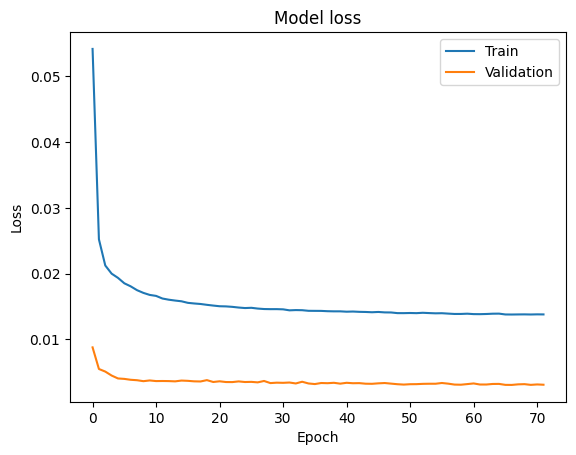

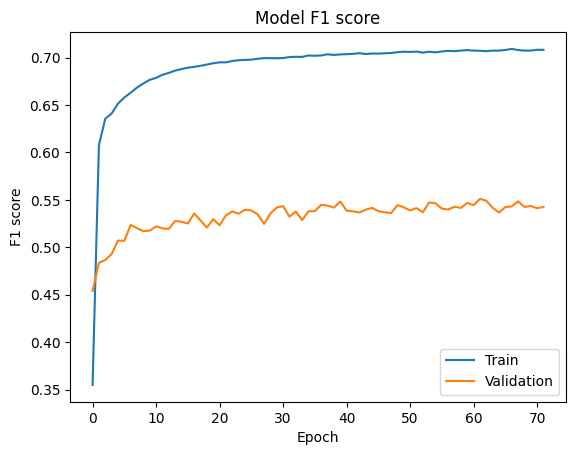

In [18]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_f1(history)

1/1 [==============================] - 0s 190ms/step
Example index in batch: 13
Image range: 0.4156863 0.8196079
Mask range: 0.0 0.0
Mask range: 9.593617e-13 0.21994714


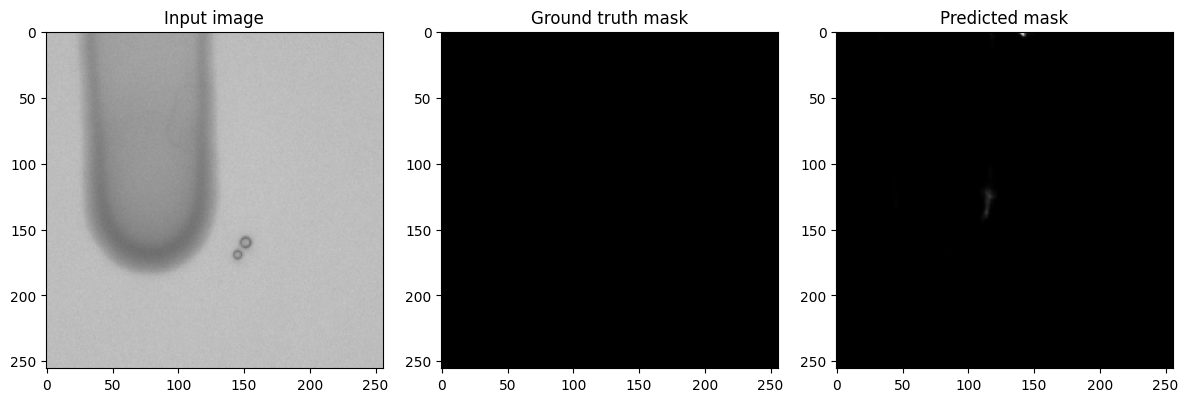

In [ ]:
# Quick sanity check: predict on a single validation batch (RAM-friendly) and
# visualize one sample alongside its ground-truth mask.

x_val_batch, y_val_batch = next(zip(val_image_generator, val_mask_generator))

# Predict on that batch
pred_batch = model.predict(x_val_batch)


i = np.random.randint(0, x_val_batch.shape[0])
print("Example index in batch:", i)
print("Image range:", x_val_batch[i].min(), x_val_batch[i].max())
print("Mask range:", y_val_batch[i].min(), y_val_batch[i].max())
print("Mask range:", pred_batch[i].min(), pred_batch[i].max())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Image
ax[0].imshow(x_val_batch[i])
ax[0].set_title("Input image")

# True mask
ax[1].imshow(y_val_batch[i].squeeze(), cmap="gray")
ax[1].set_title("Ground truth mask")

# Predicted mask
ax[2].imshow(pred_batch[i].squeeze(), cmap="gray")
ax[2].set_title("Predicted mask")

plt.tight_layout()
plt.show()


## Second iteration

### Class weight

In [ ]:
def compute_binary_class_weights(mask_root):
    """Compute background/foreground weights from mask pixel frequencies."""
    counts = np.zeros(2, dtype=np.int64)  # [bg, fg]
    for mpath in glob(f"{mask_root}/**/*.tif", recursive=True):
        m = cv2.imread(mpath, cv2.IMREAD_GRAYSCALE)
        if m is None:
            continue
        fg = (m > 0).astype(np.uint8)
        counts[1] += fg.sum()
        counts[0] += fg.size - fg.sum()
    freq = counts / counts.sum()
    w = 1.0 / (freq + 1e-8)
    w = w / w.sum() * 2  # normalize so weights avg to 1
    return w

class_weights = compute_binary_class_weights(train_mask_root)
print("bg/fg class weights:", class_weights)



bg/fg class weights: [0.03499988 1.96500012]


In [ ]:
def make_weighted_generator(img_gen, mask_gen, class_weights):
    """Wrap paired generators to add per-pixel sample weights for class imbalance."""
    bg_w, fg_w = class_weights
    while True:
        x = next(img_gen)
        y = next(mask_gen)
        y_bin = (y > 0.5).astype("float32")
        sw = y_bin * fg_w + (1.0 - y_bin) * bg_w          # shape (B,H,W,1)
        yield x, y_bin, sw


In [22]:
train_weighted_gen = make_weighted_generator(train_image_generator, train_mask_generator, class_weights)
val_weighted_gen   = make_weighted_generator(val_image_generator, val_mask_generator, class_weights)

### Train

In [ ]:


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="unet_model_patchsize256px",

    # track hyperparameters and run metadata with wandb.config
    config={
        "loss": "binary_crossentropy",
        "optimizer": "adam",
        "metric": f1,
        "epoch": 100,
        "batch_size": 16
    }
)

config = wandb.config

In [24]:

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model = simple_unet_model(patch_size, patch_size, 3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1])
model.summary()

cb = EarlyStopping(monitor='loss',
                   patience=5,
                   restore_best_weights='True',
                   mode='min')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_unet_model_patchsize256px.h5',
                             monitor='val_f1',
                             save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [25]:
history_2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data=val_generator,
    validation_steps=val_image_generator.samples // config.batch_size,
    callbacks=[cb, checkpoint, reduce_lr,
               WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models")])
wandb.finish()

Epoch 1/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0659 - f1: 0.1377

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 210s 208ms/step - loss: 0.0659 - f1: 0.1377 - val_loss: 0.0199 - val_f1: 0.3115 - lr: 1.0000e-04
Epoch 2/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0367 - f1: 0.5084

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0367 - f1: 0.5084 - val_loss: 0.0119 - val_f1: 0.4004 - lr: 1.0000e-04
Epoch 3/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0288 - f1: 0.5731

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 209s 207ms/step - loss: 0.0288 - f1: 0.5731 - val_loss: 0.0082 - val_f1: 0.4398 - lr: 1.0000e-04
Epoch 4/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0251 - f1: 0.6037

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0251 - f1: 0.6037 - val_loss: 0.0068 - val_f1: 0.4631 - lr: 1.0000e-04
Epoch 5/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0229 - f1: 0.6209

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0229 - f1: 0.6209 - val_loss: 0.0061 - val_f1: 0.4785 - lr: 1.0000e-04
Epoch 6/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0214 - f1: 0.6331

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0214 - f1: 0.6331 - val_loss: 0.0055 - val_f1: 0.4862 - lr: 1.0000e-04
Epoch 7/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0204 - f1: 0.6417

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0204 - f1: 0.6417 - val_loss: 0.0056 - val_f1: 0.4844 - lr: 1.0000e-04
Epoch 8/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0193 - f1: 0.6495

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0193 - f1: 0.6495 - val_loss: 0.0053 - val_f1: 0.4962 - lr: 1.0000e-04
Epoch 9/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0187 - f1: 0.6560

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0187 - f1: 0.6560 - val_loss: 0.0048 - val_f1: 0.5062 - lr: 1.0000e-04
Epoch 10/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0180 - f1: 0.6625

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0180 - f1: 0.6625 - val_loss: 0.0044 - val_f1: 0.5146 - lr: 1.0000e-04
Epoch 11/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0175 - f1: 0.6686

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0175 - f1: 0.6686 - val_loss: 0.0044 - val_f1: 0.5139 - lr: 1.0000e-04
Epoch 12/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0170 - f1: 0.6738

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0170 - f1: 0.6738 - val_loss: 0.0044 - val_f1: 0.5208 - lr: 1.0000e-04
Epoch 13/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0166 - f1: 0.6785

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 209s 207ms/step - loss: 0.0166 - f1: 0.6785 - val_loss: 0.0041 - val_f1: 0.5280 - lr: 1.0000e-04
Epoch 14/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0163 - f1: 0.6818

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 209s 207ms/step - loss: 0.0163 - f1: 0.6818 - val_loss: 0.0038 - val_f1: 0.5356 - lr: 1.0000e-04
Epoch 15/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0159 - f1: 0.6861

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0159 - f1: 0.6861 - val_loss: 0.0038 - val_f1: 0.5278 - lr: 1.0000e-04
Epoch 16/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0157 - f1: 0.6884

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0157 - f1: 0.6884 - val_loss: 0.0036 - val_f1: 0.5336 - lr: 1.0000e-04
Epoch 17/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0155 - f1: 0.6905

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0155 - f1: 0.6905 - val_loss: 0.0034 - val_f1: 0.5386 - lr: 1.0000e-04
Epoch 18/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0152 - f1: 0.6939

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0152 - f1: 0.6939 - val_loss: 0.0033 - val_f1: 0.5397 - lr: 1.0000e-04
Epoch 19/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0151 - f1: 0.6959

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 209s 207ms/step - loss: 0.0151 - f1: 0.6959 - val_loss: 0.0034 - val_f1: 0.5392 - lr: 1.0000e-04
Epoch 20/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0150 - f1: 0.6967
Epoch 20: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0150 - f1: 0.6967 - val_loss: 0.0034 - val_f1: 0.5442 - lr: 1.0000e-04
Epoch 21/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0147 - f1: 0.6985

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0147 - f1: 0.6985 - val_loss: 0.0033 - val_f1: 0.5476 - lr: 7.5000e-05
Epoch 22/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0145 - f1: 0.7001

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0145 - f1: 0.7001 - val_loss: 0.0032 - val_f1: 0.5509 - lr: 7.5000e-05
Epoch 23/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0144 - f1: 0.7019

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0144 - f1: 0.7019 - val_loss: 0.0032 - val_f1: 0.5422 - lr: 7.5000e-05
Epoch 24/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0143 - f1: 0.7039

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0143 - f1: 0.7039 - val_loss: 0.0032 - val_f1: 0.5436 - lr: 7.5000e-05
Epoch 25/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0142 - f1: 0.7053

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0142 - f1: 0.7053 - val_loss: 0.0032 - val_f1: 0.5451 - lr: 7.5000e-05
Epoch 26/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0141 - f1: 0.7066

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0141 - f1: 0.7066 - val_loss: 0.0031 - val_f1: 0.5490 - lr: 7.5000e-05
Epoch 27/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0140 - f1: 0.7057

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0140 - f1: 0.7057 - val_loss: 0.0031 - val_f1: 0.5536 - lr: 7.5000e-05
Epoch 28/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7072

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0139 - f1: 0.7072 - val_loss: 0.0032 - val_f1: 0.5518 - lr: 7.5000e-05
Epoch 29/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0139 - f1: 0.7077
Epoch 29: ReduceLROnPlateau reducing learning rate to 5.6249997214763425e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0139 - f1: 0.7077 - val_loss: 0.0032 - val_f1: 0.5425 - lr: 7.5000e-05
Epoch 30/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0138 - f1: 0.7087

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0138 - f1: 0.7087 - val_loss: 0.0031 - val_f1: 0.5432 - lr: 5.6250e-05
Epoch 31/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0137 - f1: 0.7096

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0137 - f1: 0.7096 - val_loss: 0.0031 - val_f1: 0.5505 - lr: 5.6250e-05
Epoch 32/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0136 - f1: 0.7098
Epoch 32: ReduceLROnPlateau reducing learning rate to 4.218749927531462e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0136 - f1: 0.7098 - val_loss: 0.0030 - val_f1: 0.5510 - lr: 5.6250e-05
Epoch 33/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0136 - f1: 0.7112

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0136 - f1: 0.7112 - val_loss: 0.0030 - val_f1: 0.5518 - lr: 4.2188e-05
Epoch 34/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0135 - f1: 0.7115

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0135 - f1: 0.7115 - val_loss: 0.0030 - val_f1: 0.5576 - lr: 4.2188e-05
Epoch 35/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0135 - f1: 0.7122
Epoch 35: ReduceLROnPlateau reducing learning rate to 3.164062582072802e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0135 - f1: 0.7122 - val_loss: 0.0030 - val_f1: 0.5621 - lr: 4.2188e-05
Epoch 36/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0134 - f1: 0.7129

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0134 - f1: 0.7129 - val_loss: 0.0030 - val_f1: 0.5573 - lr: 3.1641e-05
Epoch 37/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0134 - f1: 0.7136

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0134 - f1: 0.7136 - val_loss: 0.0030 - val_f1: 0.5565 - lr: 3.1641e-05
Epoch 38/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0133 - f1: 0.7139
Epoch 38: ReduceLROnPlateau reducing learning rate to 2.3730469365546014e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0133 - f1: 0.7139 - val_loss: 0.0030 - val_f1: 0.5558 - lr: 3.1641e-05
Epoch 39/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0133 - f1: 0.7148

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0133 - f1: 0.7148 - val_loss: 0.0030 - val_f1: 0.5512 - lr: 2.3730e-05
Epoch 40/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0133 - f1: 0.7154

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0133 - f1: 0.7154 - val_loss: 0.0029 - val_f1: 0.5540 - lr: 2.3730e-05
Epoch 41/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0132 - f1: 0.7160

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0132 - f1: 0.7160 - val_loss: 0.0030 - val_f1: 0.5526 - lr: 2.3730e-05
Epoch 42/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0132 - f1: 0.7158

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0132 - f1: 0.7158 - val_loss: 0.0029 - val_f1: 0.5587 - lr: 2.3730e-05
Epoch 43/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0132 - f1: 0.7160
Epoch 43: ReduceLROnPlateau reducing learning rate to 1.7797852706280537e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0132 - f1: 0.7160 - val_loss: 0.0030 - val_f1: 0.5601 - lr: 2.3730e-05
Epoch 44/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0132 - f1: 0.7151

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0132 - f1: 0.7151 - val_loss: 0.0029 - val_f1: 0.5631 - lr: 1.7798e-05
Epoch 45/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0131 - f1: 0.7165

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0131 - f1: 0.7165 - val_loss: 0.0029 - val_f1: 0.5564 - lr: 1.7798e-05
Epoch 46/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0131 - f1: 0.7161
Epoch 46: ReduceLROnPlateau reducing learning rate to 1.3348389529710403e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0131 - f1: 0.7161 - val_loss: 0.0029 - val_f1: 0.5556 - lr: 1.7798e-05
Epoch 47/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0131 - f1: 0.7169

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0131 - f1: 0.7169 - val_loss: 0.0029 - val_f1: 0.5576 - lr: 1.3348e-05
Epoch 48/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7171

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0130 - f1: 0.7171 - val_loss: 0.0029 - val_f1: 0.5579 - lr: 1.3348e-05
Epoch 49/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0131 - f1: 0.7168
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.0011292488343315e-05.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0131 - f1: 0.7168 - val_loss: 0.0029 - val_f1: 0.5594 - lr: 1.3348e-05
Epoch 50/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7165

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7165 - val_loss: 0.0029 - val_f1: 0.5658 - lr: 1.0011e-05
Epoch 51/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7177

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0130 - f1: 0.7177 - val_loss: 0.0029 - val_f1: 0.5589 - lr: 1.0011e-05
Epoch 52/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7182
Epoch 52: ReduceLROnPlateau reducing learning rate to 7.508469025196973e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7182 - val_loss: 0.0029 - val_f1: 0.5581 - lr: 1.0011e-05
Epoch 53/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7181

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7181 - val_loss: 0.0029 - val_f1: 0.5584 - lr: 7.5085e-06
Epoch 54/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7174

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0130 - f1: 0.7174 - val_loss: 0.0029 - val_f1: 0.5590 - lr: 7.5085e-06
Epoch 55/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7180
Epoch 55: ReduceLROnPlateau reducing learning rate to 5.63135176889773e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0130 - f1: 0.7180 - val_loss: 0.0028 - val_f1: 0.5592 - lr: 7.5085e-06
Epoch 56/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7181

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0130 - f1: 0.7181 - val_loss: 0.0028 - val_f1: 0.5601 - lr: 5.6314e-06
Epoch 57/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7182

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0130 - f1: 0.7182 - val_loss: 0.0029 - val_f1: 0.5658 - lr: 5.6314e-06
Epoch 58/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7196

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7196 - val_loss: 0.0029 - val_f1: 0.5613 - lr: 5.6314e-06
Epoch 59/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7181
Epoch 59: ReduceLROnPlateau reducing learning rate to 4.223513997203554e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7181 - val_loss: 0.0029 - val_f1: 0.5656 - lr: 5.6314e-06
Epoch 60/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7184

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0129 - f1: 0.7184 - val_loss: 0.0029 - val_f1: 0.5656 - lr: 4.2235e-06
Epoch 61/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7180

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0130 - f1: 0.7180 - val_loss: 0.0029 - val_f1: 0.5654 - lr: 4.2235e-06
Epoch 62/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7186
Epoch 62: ReduceLROnPlateau reducing learning rate to 3.167635668432922e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0129 - f1: 0.7186 - val_loss: 0.0029 - val_f1: 0.5585 - lr: 4.2235e-06
Epoch 63/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7183

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7183 - val_loss: 0.0029 - val_f1: 0.5590 - lr: 3.1676e-06
Epoch 64/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7182

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7182 - val_loss: 0.0029 - val_f1: 0.5581 - lr: 3.1676e-06
Epoch 65/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7190
Epoch 65: ReduceLROnPlateau reducing learning rate to 2.3757267513246916e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0129 - f1: 0.7190 - val_loss: 0.0029 - val_f1: 0.5655 - lr: 3.1676e-06
Epoch 66/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7193

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0130 - f1: 0.7193 - val_loss: 0.0029 - val_f1: 0.5649 - lr: 2.3757e-06
Epoch 67/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7184

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0129 - f1: 0.7184 - val_loss: 0.0029 - val_f1: 0.5576 - lr: 2.3757e-06
Epoch 68/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7189
Epoch 68: ReduceLROnPlateau reducing learning rate to 1.7817951061260828e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7189 - val_loss: 0.0029 - val_f1: 0.5581 - lr: 2.3757e-06
Epoch 69/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0130 - f1: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 207s 206ms/step - loss: 0.0130 - f1: 0.7188 - val_loss: 0.0029 - val_f1: 0.5588 - lr: 1.7818e-06
Epoch 70/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7187

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 206ms/step - loss: 0.0129 - f1: 0.7187 - val_loss: 0.0028 - val_f1: 0.5590 - lr: 1.7818e-06
Epoch 71/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7195
Epoch 71: ReduceLROnPlateau reducing learning rate to 1.3363463722271263e-06.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7195 - val_loss: 0.0028 - val_f1: 0.5597 - lr: 1.7818e-06
Epoch 72/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7195

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7195 - val_loss: 0.0028 - val_f1: 0.5599 - lr: 1.3363e-06
Epoch 73/100
1005/1005 [==============================] - ETA: 0s - loss: 0.0129 - f1: 0.7192

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1005/1005 [==============================] - 208s 207ms/step - loss: 0.0129 - f1: 0.7192 - val_loss: 0.0029 - val_f1: 0.5661 - lr: 1.3363e-06


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


batch/batch_step,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
batch/f1,▆▄▇▄▂▃▄▄▂▄▃▁▄▄▃█▃▂█▂▁▂█▃▄▇█▅█▂▅▅██▃█▄▅▇█
batch/learning_rate,███████████▆▆▆▆▆▅▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▃▂▁▂▃▃▁▁▂▁▃▁▂▁▁▁▁▁▃▁▁▃▃▃▁▃▁▂▃▁▁▁▁▃▁▁▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
epoch/f1,▁▅▇▇▇▇▇▇████████████████████████████████
epoch/learning_rate,█████████▆▆▆▆▆▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/lr,██████████▆▆▆▆▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_f1,▁▃▅▅▆▆▆▆▇▇▇▇▇█▇█▇███████████████████████
+1,...


### Checking results

In [26]:
best_val_loss = min(history_2.history['val_loss'])
best_val_f1 = max(history_2.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0027606324292719364
Best validation f1: 0.5661219954490662


Best validation loss: 0.003135383129119873

Best validation f1: 0.5524660348892212

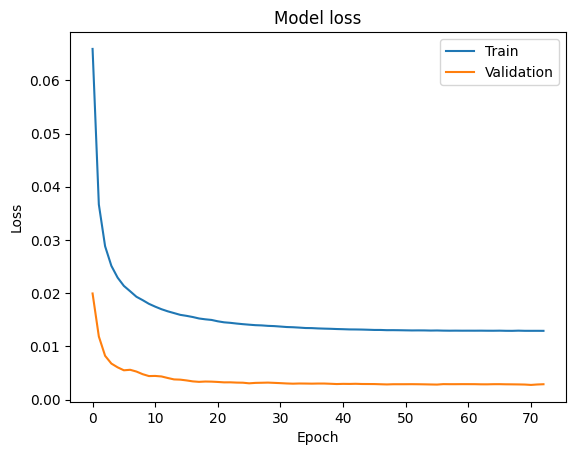

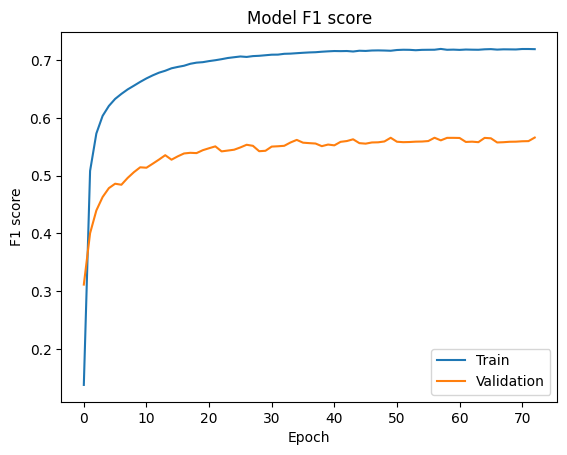

In [27]:
plot_loss(history_2.history['loss'], history_2.history['val_loss'])
plot_f1(history_2)

1/1 [==============================] - 0s 168ms/step
Example index in batch: 5
Image range: 0.0 0.65882355
Mask range: 0.0 0.0
Mask range: 4.4360445e-19 0.011428128


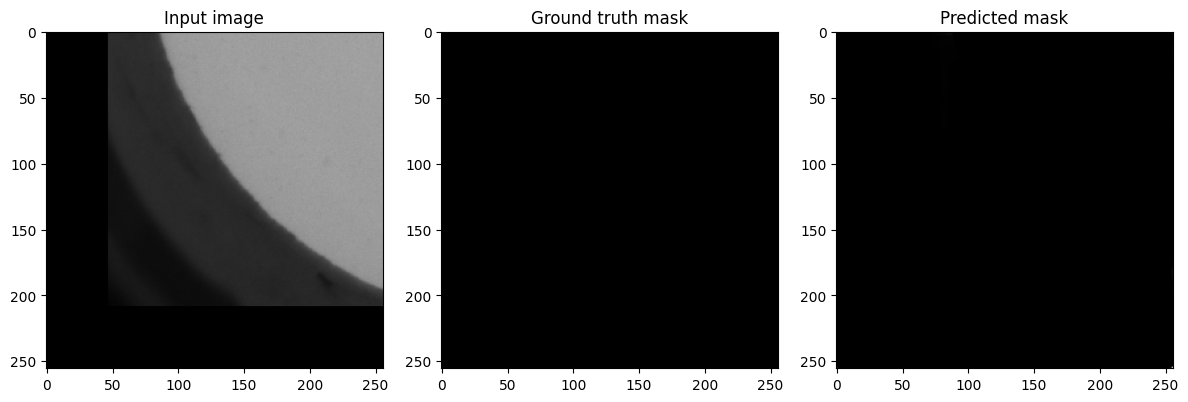

In [ ]:
# Quick sanity check: predict on a single validation batch (RAM-friendly) and
# visualize one sample alongside its ground-truth mask.
x_val_batch, y_val_batch = next(zip(val_image_generator, val_mask_generator))

# Predict on that batch
pred_batch = model.predict(x_val_batch)


i = np.random.randint(0, x_val_batch.shape[0])
print("Example index in batch:", i)
print("Image range:", x_val_batch[i].min(), x_val_batch[i].max())
print("Mask range:", y_val_batch[i].min(), y_val_batch[i].max())
print("Mask range:", pred_batch[i].min(), pred_batch[i].max())

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Image
ax[0].imshow(x_val_batch[i])
ax[0].set_title("Input image")

# True mask
ax[1].imshow(y_val_batch[i].squeeze(), cmap="gray")
ax[1].set_title("Ground truth mask")

# Predicted mask
ax[2].imshow(pred_batch[i].squeeze(), cmap="gray")
ax[2].set_title("Predicted mask")

plt.tight_layout()
plt.show()


# Multiclass Model

## First iteration

### Empty mask reduction

In [23]:
# Same empty-patch filtering for the multiclass dataset: count masks with no
# foreground and move extras to removed_* folders to control imbalance.

patch_dir = "../Task_4/multiclass_dataset_patched"

train_img  = os.path.join(patch_dir, "train_images")   # e.g. train_images/train/...
train_mask = os.path.join(patch_dir, "train_masks")    # e.g. train_masks/train/...


IMAGE_EXT = ".png"
MASK_EXT  = ".tif"

REMOVED_IMG  = os.path.join(patch_dir, "removed_images")
REMOVED_MASK = os.path.join(patch_dir, "removed_masks")
os.makedirs(REMOVED_IMG,  exist_ok=True)
os.makedirs(REMOVED_MASK, exist_ok=True)

mask_paths = glob(os.path.join(train_mask, "**","" f"*{MASK_EXT}"), recursive=True)

non_empty = []
empty = []

for mpath in mask_paths:
    mpath = Path(mpath)
    mask = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    if np.sum(mask > 0) == 0:
        empty.append(mpath)
    else:
        non_empty.append(mpath)

print("Non-empty masks:", len(non_empty))
print("Empty masks:", len(empty))

max_empty_fraction = 0.25
max_empty_to_keep  = int(max_empty_fraction * len(non_empty))

random.shuffle(empty)
keep_empty   = empty[:max_empty_to_keep]
remove_empty = empty[max_empty_to_keep:]

print(len(remove_empty), f"empty patches will be removed")

moved_masks = 0
moved_imgs  = 0

for mpath in remove_empty:
    # Example: "train_Elavendan_232430_im4_root_mask_118.tif"
    stem = mpath.stem

    if "_mask_" not in stem:
        print("WARNING: unexpected mask name pattern:", stem)
        continue

    core, patch_idx = stem.split("_mask_")  # core="train_..._im4", patch_idx="118"

    image_filename = f"{core}_{patch_idx}{IMAGE_EXT}"  # "train_..._im4_118.png"

    # preserve subfolder structure relative to train_mask_root
    rel_mask = mpath.relative_to(train_mask)  # e.g. "train/train_..._root_mask_118.tif"
    rel_dir  = rel_mask.parent                     # e.g. "train"
    rel_img  = rel_dir / image_filename            # e.g. "train/train_..._im4_118.png"

    ipath = Path(train_img, rel_img)          # full image path

    dest_mask = Path(REMOVED_MASK, rel_mask)
    dest_img  = Path(REMOVED_IMG,  rel_img)

    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    dest_img.parent.mkdir(parents=True, exist_ok=True)

    # move mask
    if mpath.exists():
        shutil.move(str(mpath), str(dest_mask))
        moved_masks += 1

    # move image
    if ipath.exists():
        shutil.move(str(ipath), str(dest_img))
        moved_imgs += 1
    else:
        print("WARNING: image not found for mask:", mpath.name, "expected:", ipath)
        
num_masks = len(mask_paths)
print("Total mask patches :", num_masks)
print("Moved masks:", moved_masks)
print("Moved images:", moved_imgs)


Non-empty masks: 13224
Empty masks: 1322
0 empty patches will be removed
Total mask patches : 14546
Moved masks: 0
Moved images: 0


### Set generator

In [24]:
patch_size = 256
batch_size = 16
n_classes = 4

In [25]:

patch_dir = "../Task_4/multiclass_dataset_patched"

def custom_generator(dataset_type, batch_size, target_size):
    """Create paired generators for multiclass data and yield image batches with one-hot masks."""

    img_dir  = f'{patch_dir}/{dataset_type}_images'
    mask_dir = f'{patch_dir}/{dataset_type}_masks'

    # Count
    img_paths  = glob(os.path.join(img_dir, '**', '*.png'), recursive=True)
    mask_paths = glob(os.path.join(mask_dir, '**', '*.tif'), recursive=True)

    num_img = len(img_paths)
    num_masks = len(mask_paths)
    print(f"[INFO] {dataset_type}: {len(img_paths)} images, {len(mask_paths)} masks")


    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_images',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        seed=42)

    mask_generator = mask_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_masks',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        color_mode='grayscale',
        seed=42)
    
    # to_categorical
    def gen():
        while True:
            X = image_generator.next()
            Y = mask_generator.next()
            Y = to_categorical(Y.squeeze(-1), num_classes=4)
            yield X, Y

    g = gen()

    return g, num_img, num_masks


In [26]:
train_gen, t_img, t_masks = custom_generator('train', batch_size=16, target_size=(patch_size,patch_size))
val_gen, v_img, v_masks  = custom_generator('val', batch_size=16, target_size=(patch_size,patch_size))

[INFO] train: 14546 images, 14546 masks
Found 14546 images belonging to 1 classes.
Found 14546 images belonging to 1 classes.
[INFO] val: 2057 images, 2057 masks
Found 2057 images belonging to 1 classes.
Found 2057 images belonging to 1 classes.


In [27]:
# Sanity check

X_batch, Y_batch = next(train_gen)
print("X_batch:", X_batch.shape, X_batch.dtype)
print("Y_batch:", Y_batch.shape, Y_batch.dtype)

# convert one-hot back to labels
y_labels = np.argmax(Y_batch, axis=-1)  # shape (B, H, W)
print("Unique labels in this batch:", np.unique(y_labels))

X_batch: (16, 256, 256, 3) float32
Y_batch: (16, 256, 256, 4) float32
Unique labels in this batch: [0 1 2]


### Model

In [28]:

# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="multiclass_unet_model_patchsize256px",

    # track hyperparameters and run metadata with wandb.config
    config={
        "loss": "categorical_crossentropy",
        "optimizer": "adam",
        "f1_score": f1,
        "epoch": 100,
        "batch_size": 16
    }
)

# [optional] use wandb.config as your config
config = wandb.config

In [29]:
# *AlMOST* SAME AS NOTEBOOK 7
# Diff 1: output layer Conv2D(n_classes, (1, 1), activation='softmax')(c9)
# Diff 2: loss='categorical_crossentropy'
# Diff 3: multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning

def multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes): # changed
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9) # changed
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1]) # changed
    # model.summary()
    
    return model

In [30]:
model = multiclass_unet_model(patch_size, patch_size, 3, n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1]) # changed
model.summary()

cb = EarlyStopping(monitor='val_f1',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_multiclass_unet_model_patchsize256px_2.h5',
                             monitor='val_loss',
                             save_best_only=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [31]:
history = model.fit(
    train_gen,
    steps_per_epoch=t_img//config.batch_size,
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data = val_gen,
    validation_steps = v_img//config.batch_size,
    callbacks=[cb, checkpoint,
               WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models")]
)
wandb.finish()

Epoch 1/100
908/909 [============================>.] - ETA: 0s - loss: 0.4018 - f1: 0.9549

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 223s 243ms/step - loss: 0.4017 - f1: 0.9549 - val_loss: 0.0260 - val_f1: 0.9924
Epoch 2/100
909/909 [==============================] - ETA: 0s - loss: 0.0843 - f1: 0.9703

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 222s 244ms/step - loss: 0.0843 - f1: 0.9703 - val_loss: 0.0217 - val_f1: 0.9925
Epoch 3/100
909/909 [==============================] - ETA: 0s - loss: 0.0681 - f1: 0.9732

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 228s 251ms/step - loss: 0.0681 - f1: 0.9732 - val_loss: 0.0172 - val_f1: 0.9936
Epoch 4/100
909/909 [==============================] - ETA: 0s - loss: 0.0571 - f1: 0.9787

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 223s 245ms/step - loss: 0.0571 - f1: 0.9787 - val_loss: 0.0118 - val_f1: 0.9961
Epoch 5/100
909/909 [==============================] - ETA: 0s - loss: 0.0447 - f1: 0.9842

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 224s 246ms/step - loss: 0.0447 - f1: 0.9842 - val_loss: 0.0091 - val_f1: 0.9968
Epoch 6/100
909/909 [==============================] - ETA: 0s - loss: 0.0399 - f1: 0.9868

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 218s 240ms/step - loss: 0.0399 - f1: 0.9868 - val_loss: 0.0072 - val_f1: 0.9975
Epoch 7/100
909/909 [==============================] - ETA: 0s - loss: 0.0353 - f1: 0.9881

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 219s 241ms/step - loss: 0.0353 - f1: 0.9881 - val_loss: 0.0060 - val_f1: 0.9979
Epoch 8/100
909/909 [==============================] - ETA: 0s - loss: 0.0302 - f1: 0.9892

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 220s 242ms/step - loss: 0.0302 - f1: 0.9892 - val_loss: 0.0060 - val_f1: 0.9977
Epoch 9/100
909/909 [==============================] - ETA: 0s - loss: 0.0286 - f1: 0.9896

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 214s 235ms/step - loss: 0.0286 - f1: 0.9896 - val_loss: 0.0052 - val_f1: 0.9981
Epoch 10/100
909/909 [==============================] - ETA: 0s - loss: 0.0275 - f1: 0.9899

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 213s 234ms/step - loss: 0.0275 - f1: 0.9899 - val_loss: 0.0061 - val_f1: 0.9978
Epoch 11/100
909/909 [==============================] - ETA: 0s - loss: 0.0268 - f1: 0.9901

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 211s 232ms/step - loss: 0.0268 - f1: 0.9901 - val_loss: 0.0049 - val_f1: 0.9982
Epoch 12/100
909/909 [==============================] - ETA: 0s - loss: 0.0262 - f1: 0.9904

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 212s 234ms/step - loss: 0.0262 - f1: 0.9904 - val_loss: 0.0054 - val_f1: 0.9981
Epoch 13/100
909/909 [==============================] - ETA: 0s - loss: 0.0256 - f1: 0.9905

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 212s 233ms/step - loss: 0.0256 - f1: 0.9905 - val_loss: 0.0058 - val_f1: 0.9981
Epoch 14/100
909/909 [==============================] - ETA: 0s - loss: 0.0249 - f1: 0.9907

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 214s 235ms/step - loss: 0.0249 - f1: 0.9907 - val_loss: 0.0043 - val_f1: 0.9985
Epoch 15/100
909/909 [==============================] - ETA: 0s - loss: 0.0247 - f1: 0.9908

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 213s 234ms/step - loss: 0.0247 - f1: 0.9908 - val_loss: 0.0045 - val_f1: 0.9984
Epoch 16/100
909/909 [==============================] - ETA: 0s - loss: 0.0250 - f1: 0.9907

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 214s 235ms/step - loss: 0.0250 - f1: 0.9907 - val_loss: 0.0042 - val_f1: 0.9985
Epoch 17/100
909/909 [==============================] - ETA: 0s - loss: 0.0243 - f1: 0.9909

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 214s 235ms/step - loss: 0.0243 - f1: 0.9909 - val_loss: 0.0047 - val_f1: 0.9983
Epoch 18/100
909/909 [==============================] - ETA: 0s - loss: 0.0236 - f1: 0.9911

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 215s 236ms/step - loss: 0.0236 - f1: 0.9911 - val_loss: 0.0046 - val_f1: 0.9983
Epoch 19/100
909/909 [==============================] - ETA: 0s - loss: 0.0237 - f1: 0.9911

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 213s 234ms/step - loss: 0.0237 - f1: 0.9911 - val_loss: 0.0044 - val_f1: 0.9984
Epoch 20/100
909/909 [==============================] - ETA: 0s - loss: 0.0243 - f1: 0.9909

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


909/909 [==============================] - 213s 234ms/step - loss: 0.0243 - f1: 0.9909 - val_loss: 0.0043 - val_f1: 0.9984
Epoch 21/100
909/909 [==============================] - ETA: 0s - loss: 0.0229 - f1: 0.9913

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


909/909 [==============================] - 212s 233ms/step - loss: 0.0229 - f1: 0.9913 - val_loss: 0.0043 - val_f1: 0.9985


batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇██
batch/f1,▁▄▆▆▆▆▇▇▇███████████████████████████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▆▆▆▆▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/f1,▁▄▅▆▇▇▇██████████████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_f1,▁▁▂▅▆▇▇▇█▇███████████
epoch/val_loss,█▇▅▃▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁
batch/batch_step,19105


In [32]:
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.004239042289555073
Best validation f1: 0.9984860420227051


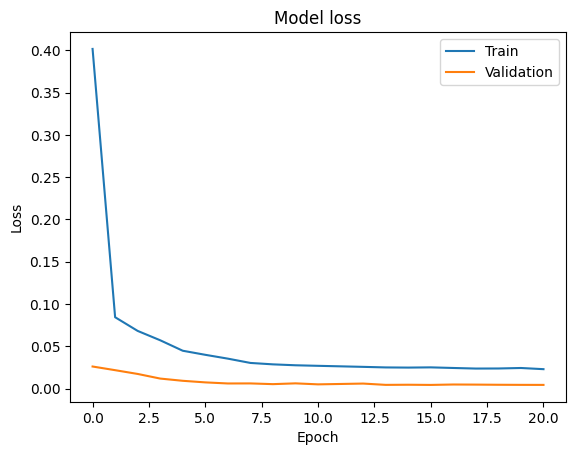

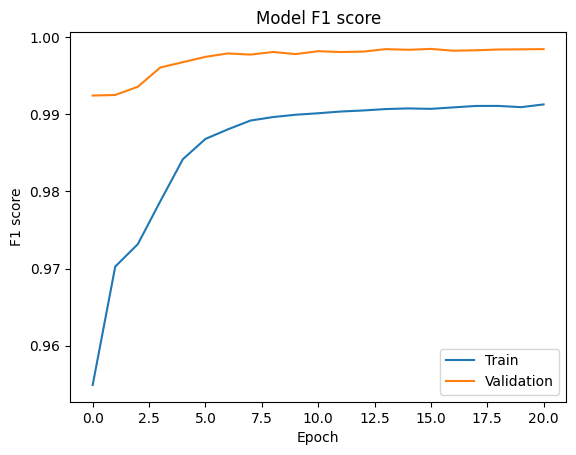

In [33]:
plot_loss(history.history['loss'], history.history['val_loss'])
plot_f1(history)

### Evaluation

In [34]:
# Load the model
patch_size = 256
example_file_name = 'maciej_czerniak_243552_multiclass_unet_model_patchsize256px_2.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [35]:
eval_batch = 4
val_gen_eval, v_img_eval, _ = custom_generator('val', batch_size=eval_batch, target_size=(patch_size, patch_size))
val_steps = v_img_eval // eval_batch
metrics = eval_full_val(model, val_gen_eval, val_steps, predict_batch_size=eval_batch)
for cls, m in metrics.items():
    print(f"{cls:11s} | F1={m['f1']:.4f} | IoU={m['iou']:.4f} | Prec={m['precision']:.4f} | Rec={m['recall']:.4f} | pixels={m['support']}")

[INFO] val: 2057 images, 2057 masks
Found 2057 images belonging to 1 classes.
Found 2057 images belonging to 1 classes.
1/1 [==============================] - 0s 25ms/step
background  | F1=0.9993 | IoU=0.9986 | Prec=0.9991 | Rec=0.9994 | pixels=133766401
root        | F1=0.8521 | IoU=0.7423 | Prec=0.8869 | Rec=0.8199 | pixels=559827
shoot       | F1=0.9353 | IoU=0.8785 | Prec=0.9299 | Rec=0.9408 | pixels=410124
seed        | F1=0.0000 | IoU=0.0000 | Prec=0.0000 | Rec=0.0000 | pixels=5664


background  | F1 = 0.9991 | IoU = 0.9982 | Prec = 0.9989 | Rec = 0.9993 | pixels = 6232976

root        | F1 = 0.8513 | IoU = 0.7412 | Prec = 0.8661 | Rec = 0.8371 | pixels = 33335

shoot       | F1 = 0.9274 | IoU = 0.8646 | Prec = 0.9406 | Rec = 0.9146 | pixels = 24621

seed        | F1 = 0.0000 | IoU = 0.0000 | Prec = 0.0000 | Rec = 0.0000 | pixels = 524

## Second iteration

### Preparation

In [15]:

def compute_class_weights_from_generator(generator, steps, n_classes):
    """Estimate per-class pixel weights by iterating over a one-hot generator."""
    pixel_counts = np.zeros(n_classes, dtype=np.int64)

    for _ in range(steps):
        X_batch, Y_batch = next(generator)   # Y_batch shape: (B, H, W, C)
        
        # convert one-hot mask -> class indices
        Y_indices = np.argmax(Y_batch, axis=-1)   # shape (B, H, W)

        # count pixels of each class
        for c in range(n_classes):
            pixel_counts[c] += np.sum(Y_indices == c)

    total = np.sum(pixel_counts)
    class_freq = pixel_counts / total

    # balanced class weights = inverse frequency
    class_weights = 1.0 / (class_freq + 1e-8)

    # normalize
    class_weights = class_weights / np.sum(class_weights) * n_classes

    return pixel_counts, class_weights


In [16]:
n_classes = 4
batches_to_scan = t_masks//batch_size   # scan subset of training data

pixel_counts, class_weights = compute_class_weights_from_generator(
    train_gen, 
    steps=batches_to_scan,
    n_classes=n_classes
)

print("Pixel counts:", pixel_counts)
print("Class weights:", class_weights)


Pixel counts: [1046199314   18371905   17453786     236499]
Class weights: [8.80789788e-04 5.01570816e-02 5.27954858e-02 3.89616664e+00]


In [100]:
cw = class_weights.tolist()

In [101]:
cw

[0.0008807897880546482,
 0.050157081627770286,
 0.05279548575811626,
 3.896166642826059]

Base on my research I need to inplement weights into loss function for multiclass model.

Source of the function: [Source](https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d)

In [17]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
loss = weighted_categorical_crossentropy(class_weights)

### Training

In [ ]:


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="multiclass_unet_model_patchsize256px",

    # track hyperparameters and run metadata with wandb.config
    config={
        "loss": "categorical_crossentropy",
        "optimizer": "adam",
        "f1_score": f1,
        "epoch": 100,
        "batch_size": 16,
        "class_weights": class_weights.tolist()
    }
)

# [optional] use wandb.config as your config
config = wandb.config

In [ ]:
# *AlMOST* SAME AS NOTEBOOK 7
# Diff 1: output layer Conv2D(n_classes, (1, 1), activation='softmax')(c9)
# Diff 2: loss='categorical_crossentropy'
# Diff 3: multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning

def multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes): # changed
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9) # changed
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss=loss, metrics=[f1]) # changed
    # model.summary()
    
    return model

In [54]:
model = multiclass_unet_model(patch_size, patch_size, 3, n_classes)
model.compile(optimizer='adam', loss=loss, metrics=[f1]) # changed
model.summary()

cb = EarlyStopping(monitor='val_f1',
                   patience=5,
                   restore_best_weights='True',
                   mode='max')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_multiclass_unet_model_patchsize256px_balanced.h5',
                             monitor='val_loss',
                             save_best_only=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_27 (Dropout)           (None, 256, 256, 16  0           ['conv2d_57[0][0]']              
                                )                                                           

In [55]:
history_2 = model.fit(
    train_gen,
    steps_per_epoch=t_img//config.batch_size,
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data = val_gen,
    validation_steps = v_img//config.batch_size,
    callbacks=[cb, checkpoint,
               WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models")]
)
wandb.finish()

Epoch 1/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0056 - f1: 0.0266

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1042/1042 [==============================] - 237s 227ms/step - loss: 0.0056 - f1: 0.0266 - val_loss: 0.0020 - val_f1: 0.1128
Epoch 2/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0353

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 236s 227ms/step - loss: 0.0050 - f1: 0.0353 - val_loss: 0.0021 - val_f1: 0.1131
Epoch 3/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0369

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0369 - val_loss: 0.0020 - val_f1: 0.1148
Epoch 4/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0437

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0437 - val_loss: 0.0020 - val_f1: 0.1510
Epoch 5/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0561

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0561 - val_loss: 0.0020 - val_f1: 0.1547
Epoch 6/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0567

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0567 - val_loss: 0.0020 - val_f1: 0.1509
Epoch 7/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0540

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0540 - val_loss: 0.0020 - val_f1: 0.1169
Epoch 8/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0384

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 235s 226ms/step - loss: 0.0050 - f1: 0.0384 - val_loss: 0.0020 - val_f1: 0.1174
Epoch 9/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0368

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0368 - val_loss: 0.0020 - val_f1: 0.1158
Epoch 10/100
1042/1042 [==============================] - ETA: 0s - loss: 0.0050 - f1: 0.0367

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


1042/1042 [==============================] - 236s 226ms/step - loss: 0.0050 - f1: 0.0367 - val_loss: 0.0020 - val_f1: 0.1147


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
batch/f1,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/f1,▁▃▃▅██▇▄▃▃
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁
epoch/val_f1,▁▁▁▇█▇▂▂▁▁
epoch/val_loss,▁█▅▃▁▃▅▃▅▆
batch/batch_step,10445


In [56]:
best_val_loss = min(history_2.history['val_loss'])
best_val_f1 = max(history_2.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.0019551708828657866
Best validation f1: 0.15472236275672913


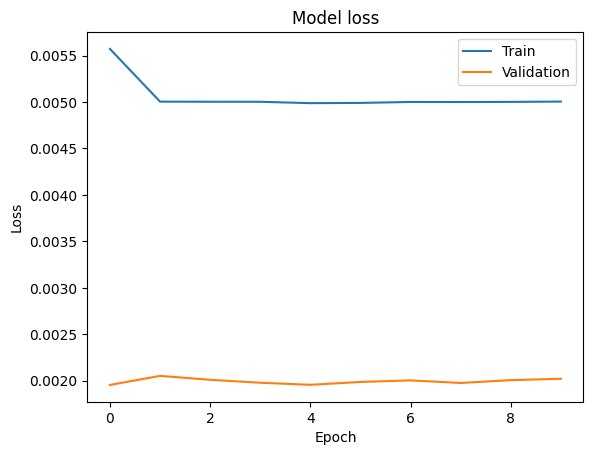

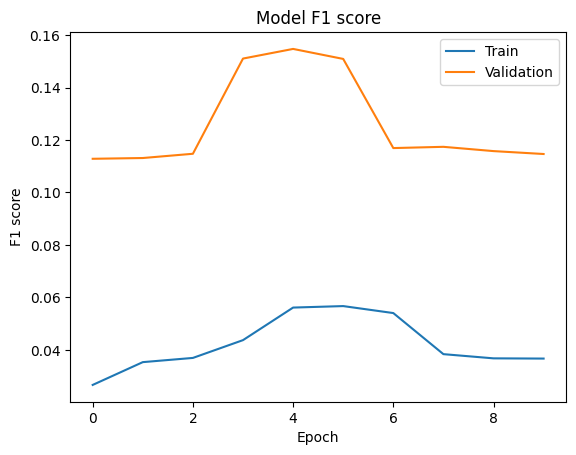

In [57]:
plot_loss(history_2.history['loss'], history_2.history['val_loss'])
plot_f1(history_2)

### Evaluation

In [18]:
# Load the model
patch_size = 256
example_file_name = f'maciej_czerniak_243552_multiclass_unet_model_patchsize256px_balanced.h5'
model = load_model(example_file_name, custom_objects={"f1": f1, 'loss': loss})

In [19]:
metrics = eval_full_val(model, val_gen_eval, val_steps, predict_batch_size=eval_batch)
for cls, m in metrics.items():
    print(f"{cls:11s} | F1={m['f1']:.4f} | IoU={m['iou']:.4f} | Prec={m['precision']:.4f} | Rec={m['recall']:.4f} | pixels={m['support']}")

1/1 [==============================] - 0s 31ms/step
background  | F1=0.9963 | IoU=0.9927 | Prec=0.9927 | Rec=1.0000 | pixels=133569793
root        | F1=0.0000 | IoU=0.0000 | Prec=0.0000 | Rec=0.0000 | pixels=559827
shoot       | F1=0.0000 | IoU=0.0000 | Prec=0.0000 | Rec=0.0000 | pixels=410124
seed        | F1=0.0000 | IoU=0.0000 | Prec=0.0000 | Rec=0.0000 | pixels=5664


background  | F1 = 0.9881 | IoU = 0.9766 | Prec = 1.0000 | Rec = 0.9766 | pixels = 6248604

root        | F1 = 0.4945 | IoU = 0.3285 | Prec = 0.3290 | Rec = 0.9949 | pixels = 23028

shoot       | F1 = 0.2704 | IoU = 0.1563 | Prec = 0.1582 | Rec = 0.9313 | pixels = 19692

seed        | F1 = 0.0730 | IoU = 0.0379 | Prec = 0.0379 | Rec = 1.0000 | pixels = 132

## Third iteration

### Empty mask reduction

In [8]:
# Same empty-patch filtering for the multiclass dataset: count masks with no
# foreground and move extras to removed_* folders to control imbalance.

patch_dir = "../Task_4/multiclass_dataset_patched"

train_img  = os.path.join(patch_dir, "train_images")   # e.g. train_images/train/...
train_mask = os.path.join(patch_dir, "train_masks")    # e.g. train_masks/train/...


IMAGE_EXT = ".png"
MASK_EXT  = ".tif"

REMOVED_IMG  = os.path.join(patch_dir, "removed_images")
REMOVED_MASK = os.path.join(patch_dir, "removed_masks")
os.makedirs(REMOVED_IMG,  exist_ok=True)
os.makedirs(REMOVED_MASK, exist_ok=True)

mask_paths = glob(os.path.join(train_mask, "**","" f"*{MASK_EXT}"), recursive=True)

non_empty = []
empty = []

for mpath in mask_paths:
    mpath = Path(mpath)
    mask = cv2.imread(str(mpath), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        continue

    if np.sum(mask > 0) == 0:
        empty.append(mpath)
    else:
        non_empty.append(mpath)

print("Non-empty masks:", len(non_empty))
print("Empty masks:", len(empty))

max_empty_fraction = 0.10
max_empty_to_keep  = int(max_empty_fraction * len(non_empty))

random.shuffle(empty)
keep_empty   = empty[:max_empty_to_keep]
remove_empty = empty[max_empty_to_keep:]

print(len(remove_empty), f"empty patches will be removed")

moved_masks = 0
moved_imgs  = 0

for mpath in remove_empty:
    # Example: "train_Elavendan_232430_im4_root_mask_118.tif"
    stem = mpath.stem

    if "_mask_" not in stem:
        print("WARNING: unexpected mask name pattern:", stem)
        continue

    core, patch_idx = stem.split("_mask_")  # core="train_..._im4", patch_idx="118"

    image_filename = f"{core}_{patch_idx}{IMAGE_EXT}"  # "train_..._im4_118.png"

    # preserve subfolder structure relative to train_mask_root
    rel_mask = mpath.relative_to(train_mask)  # e.g. "train/train_..._root_mask_118.tif"
    rel_dir  = rel_mask.parent                     # e.g. "train"
    rel_img  = rel_dir / image_filename            # e.g. "train/train_..._im4_118.png"

    ipath = Path(train_img, rel_img)          # full image path

    dest_mask = Path(REMOVED_MASK, rel_mask)
    dest_img  = Path(REMOVED_IMG,  rel_img)

    dest_mask.parent.mkdir(parents=True, exist_ok=True)
    dest_img.parent.mkdir(parents=True, exist_ok=True)

    # move mask
    if mpath.exists():
        shutil.move(str(mpath), str(dest_mask))
        moved_masks += 1

    # move image
    if ipath.exists():
        shutil.move(str(ipath), str(dest_img))
        moved_imgs += 1
    else:
        print("WARNING: image not found for mask:", mpath.name, "expected:", ipath)
        
num_masks = len(mask_paths)
print("Total mask patches :", num_masks)
print("Moved masks:", moved_masks)
print("Moved images:", moved_imgs)


Non-empty masks: 13224
Empty masks: 1322
0 empty patches will be removed
Total mask patches : 14546
Moved masks: 0
Moved images: 0


### New loss implementation

In [9]:
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    """Mean per-class Dice coefficient for one-hot targets and predictions."""
    num_classes = K.int_shape(y_pred)[-1]

    dice = 0
    for c in range(num_classes):
        y_true_c = y_true[..., c]
        y_pred_c = y_pred[..., c]

        intersection = K.sum(y_true_c * y_pred_c)
        union = K.sum(y_true_c) + K.sum(y_pred_c)

        dice_c = (2. * intersection + smooth) / (union + smooth)
        dice += dice_c

    return dice / num_classes

def dice_loss(y_true, y_pred):
    """Dice loss wrapper around the multiclass Dice coefficient."""
    return 1 - dice_coef_multiclass(y_true, y_pred)

cce = tf.keras.losses.CategoricalCrossentropy()

def combined_loss(y_true, y_pred):
    """Hybrid loss: categorical cross-entropy plus multiclass Dice loss."""
    return cce(y_true, y_pred) + dice_loss(y_true, y_pred)


### Data generator with data agumenatation

In [10]:

patch_dir = "../Task_4/multiclass_dataset_patched"

def custom_generator(dataset_type, batch_size, target_size , augment=False):
    """Paired image/mask generators with optional augmentation for multiclass data."""

    img_dir  = f'{patch_dir}/{dataset_type}_images'
    mask_dir = f'{patch_dir}/{dataset_type}_masks'

    # Count
    img_paths  = glob(os.path.join(img_dir, '**', '*.png'), recursive=True)
    mask_paths = glob(os.path.join(mask_dir, '**', '*.tif'), recursive=True)

    num_img = len(img_paths)
    num_masks = len(mask_paths)
    print(f"[INFO] {dataset_type}: {len(img_paths)} images, {len(mask_paths)} masks")

    if augment and dataset_type == "train":
        aug_args_img = dict(
            rotation_range=12,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            shear_range=5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=(0.9, 1.1),
            fill_mode='reflect',
        )
        aug_args_masks = dict(
            rotation_range=12,
            width_shift_range=0.05,
            height_shift_range=0.05,
            zoom_range=0.1,
            shear_range=5,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
        )
    else:
        aug_args_img = dict()
        aug_args_masks = dict()

    image_datagen = ImageDataGenerator(**aug_args_img)
    mask_datagen = ImageDataGenerator(**aug_args_masks)

    image_generator = image_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_images',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        seed=42)

    mask_generator = mask_datagen.flow_from_directory(
        f'{patch_dir}/{dataset_type}_masks',
        class_mode=None,
        batch_size=batch_size,
        target_size=target_size,
        color_mode='grayscale',
        seed=42)
    
    # to_categorical
    def gen():
        while True:
            X = image_generator.next()
            Y = mask_generator.next()

            # Safety: clip to valid class range. Augmentations may produce out-of-range values (floats).
            Y_lbl = np.rint(Y).astype(np.uint8)   # force integers
            Y_lbl = np.clip(Y_lbl, 0, 3)
            Y = to_categorical(Y_lbl.squeeze(-1), num_classes=4)
            yield X, Y

    g = gen()

    return g, num_img, num_masks


In [11]:
patch_size = 256
batch_size = 6
n_classes = 4

In [12]:
train_gen, t_img, t_masks = custom_generator('train', batch_size=6, target_size=(patch_size,patch_size), augment=True)
val_gen, v_img, v_masks  = custom_generator('val', batch_size=6, target_size=(patch_size,patch_size), augment=False)

[INFO] train: 14546 images, 14546 masks
Found 14546 images belonging to 1 classes.
Found 14546 images belonging to 1 classes.
[INFO] val: 2057 images, 2057 masks
Found 2057 images belonging to 1 classes.
Found 2057 images belonging to 1 classes.


In [13]:
# Sanity check

X_batch, Y_batch = next(train_gen)
print("X_batch:", X_batch.shape, X_batch.dtype)
print("Y_batch:", Y_batch.shape, Y_batch.dtype)

# convert one-hot back to labels
y_labels = np.argmax(Y_batch, axis=-1)  # shape (B, H, W)
print("Unique labels in this batch:", np.unique(y_labels))

X_batch: (6, 256, 256, 3) float32
Y_batch: (6, 256, 256, 4) float32
Unique labels in this batch: [0 1 2]


### Train

In [14]:


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="multiclass_unet_model_patchsize256px",

    # track hyperparameters and run metadata with wandb.config
    config={
        "loss": combined_loss,
        "optimizer": "adam",
        "f1_score": f1,
        "epoch": 100,
        "batch_size": 6,
        "patch_size": 256,
        "n_classes": 4
    }
)

# [optional] use wandb.config as your config
config = wandb.config

wandb: Currently logged in as: 243552 (242621-breda-university-of-applied-sciences) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
# *AlMOST* SAME AS NOTEBOOK 7
# Diff 1: output layer Conv2D(n_classes, (1, 1), activation='softmax')(c9)
# Diff 2: loss='categorical_crossentropy'
# Diff 3: multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes)

# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning

def multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_classes): # changed
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9) # changed
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss=combined_loss, metrics=[f1]) # changed
    # model.summary()
    
    return model

In [16]:
model = multiclass_unet_model(config.patch_size, config.patch_size, 3, config.n_classes)
model.compile(optimizer='adam', loss=combined_loss, metrics=[f1]) # changed
model.summary()

cb = EarlyStopping(monitor='val_loss',
                   patience=5,
                   restore_best_weights='True',
                   mode='min')

checkpoint = ModelCheckpoint(filepath='maciej_czerniak_243552_multiclass_unet_model_patchsize256px_combined_loss.h5',
                             monitor='val_loss',
                             save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
history_3 = model.fit(
    train_gen,
    steps_per_epoch=t_img//config.batch_size,
    epochs=config.epoch,
    batch_size=config.batch_size,
    validation_data = val_gen,
    validation_steps = v_img//config.batch_size,
    callbacks=[cb, checkpoint,
               WandbMetricsLogger(log_freq=5),
               WandbModelCheckpoint("models")]
)
wandb.finish()

Epoch 1/100
2424/2424 [==============================] - ETA: 0s - loss: 1.1236 - f1: 0.9559

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 405s 165ms/step - loss: 1.1236 - f1: 0.9559 - val_loss: 0.8036 - val_f1: 0.9893
Epoch 2/100
2424/2424 [==============================] - ETA: 0s - loss: 0.9046 - f1: 0.9571

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.9046 - f1: 0.9571 - val_loss: 0.7753 - val_f1: 0.9898
Epoch 3/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8927 - f1: 0.9572

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 399s 165ms/step - loss: 0.8927 - f1: 0.9572 - val_loss: 0.7712 - val_f1: 0.9915
Epoch 4/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8896 - f1: 0.9567

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 398s 164ms/step - loss: 0.8896 - f1: 0.9567 - val_loss: 0.7589 - val_f1: 0.9941
Epoch 5/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8896 - f1: 0.9571

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 397s 164ms/step - loss: 0.8896 - f1: 0.9571 - val_loss: 0.7755 - val_f1: 0.9938
Epoch 6/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8841 - f1: 0.9574

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 398s 164ms/step - loss: 0.8841 - f1: 0.9574 - val_loss: 0.7610 - val_f1: 0.9948
Epoch 7/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8885 - f1: 0.9567

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 398s 164ms/step - loss: 0.8885 - f1: 0.9567 - val_loss: 0.7975 - val_f1: 0.9886
Epoch 8/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8880 - f1: 0.9572

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 399s 165ms/step - loss: 0.8880 - f1: 0.9572 - val_loss: 0.7556 - val_f1: 0.9946
Epoch 9/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8805 - f1: 0.9572

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 402s 166ms/step - loss: 0.8805 - f1: 0.9572 - val_loss: 0.7548 - val_f1: 0.9947
Epoch 10/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8806 - f1: 0.9572

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8806 - f1: 0.9572 - val_loss: 0.7971 - val_f1: 0.9938
Epoch 11/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8824 - f1: 0.9569

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8824 - f1: 0.9569 - val_loss: 0.7359 - val_f1: 0.9947
Epoch 12/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8800 - f1: 0.9573

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8800 - f1: 0.9573 - val_loss: 0.7486 - val_f1: 0.9951
Epoch 13/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8795 - f1: 0.9571

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8795 - f1: 0.9571 - val_loss: 0.7416 - val_f1: 0.9937
Epoch 14/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8759 - f1: 0.9561

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8759 - f1: 0.9561 - val_loss: 0.7272 - val_f1: 0.9938
Epoch 15/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8733 - f1: 0.9540

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8733 - f1: 0.9540 - val_loss: 0.7272 - val_f1: 0.9812
Epoch 16/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8634 - f1: 0.9540

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8634 - f1: 0.9540 - val_loss: 0.7110 - val_f1: 0.9953
Epoch 17/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8582 - f1: 0.9537

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 399s 165ms/step - loss: 0.8582 - f1: 0.9537 - val_loss: 0.7180 - val_f1: 0.9952
Epoch 18/100
2424/2424 [==============================] - ETA: 0s - loss: 0.8880 - f1: 0.9568

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 400s 165ms/step - loss: 0.8880 - f1: 0.9568 - val_loss: 0.8122 - val_f1: 0.9928
Epoch 19/100
2424/2424 [==============================] - ETA: 0s - loss: 0.9336 - f1: 0.9607

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 401s 165ms/step - loss: 0.9336 - f1: 0.9607 - val_loss: 0.8127 - val_f1: 0.9925
Epoch 20/100
2424/2424 [==============================] - ETA: 0s - loss: 0.9232 - f1: 0.9588

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.1s


2424/2424 [==============================] - 401s 165ms/step - loss: 0.9232 - f1: 0.9588 - val_loss: 0.8011 - val_f1: 0.9862
Epoch 21/100
2424/2424 [==============================] - ETA: 0s - loss: 0.9057 - f1: 0.9559

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (models)... Done. 0.0s


2424/2424 [==============================] - 401s 165ms/step - loss: 0.9057 - f1: 0.9559 - val_loss: 0.7568 - val_f1: 0.9810


batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
batch/f1,▁███████████████████████████████████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/f1,▃▄▄▄▄▅▄▅▅▅▄▅▄▃▁▁▁▄█▆▃
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▃▃▂
epoch/val_f1,▅▅▆▇▇█▅██▇██▇▇▁██▇▇▄▁
epoch/val_loss,▇▅▅▄▅▄▇▄▄▇▃▄▃▂▂▁▁██▇▄
batch/batch_step,50920


In [18]:
best_val_loss = min(history_3.history['val_loss'])
best_val_f1 = max(history_3.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.710985004901886
Best validation f1: 0.9953308701515198


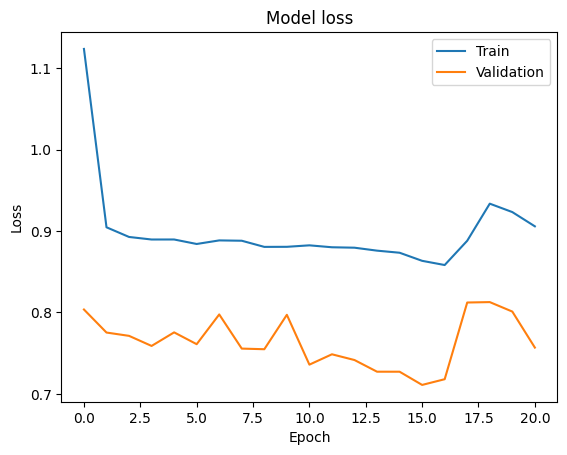

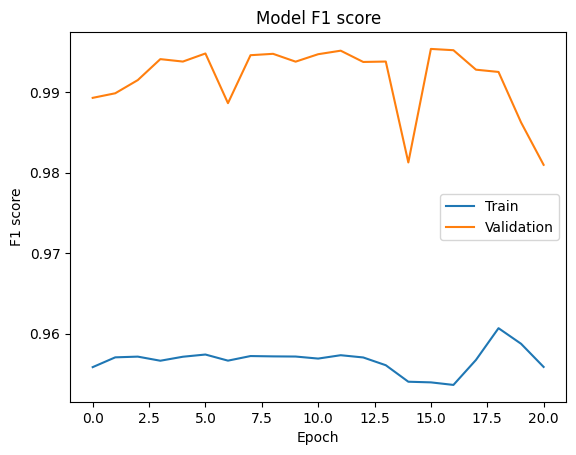

In [19]:
plot_loss(history_3.history['loss'], history_3.history['val_loss'])
plot_f1(history_3)

### Evaluation

In [20]:
# Load the model
patch_size = 256
example_file_name = f'maciej_czerniak_243552_multiclass_unet_model_patchsize256px_combined_loss.h5'
model = load_model(example_file_name, custom_objects={"f1": f1, "combined_loss": combined_loss})

In [22]:
eval_batch = 4
val_gen_eval, v_img_eval, _ = custom_generator('val', batch_size=eval_batch, target_size=(patch_size, patch_size))
val_steps = v_img_eval // eval_batch
metrics = eval_full_val(model, val_gen_eval, val_steps, predict_batch_size=eval_batch)
for cls, m in metrics.items():
    print(f"{cls:11s} | F1={m['f1']:.4f} | IoU={m['iou']:.4f} | Prec={m['precision']:.4f} | Rec={m['recall']:.4f} | pixels={m['support']}")

[INFO] val: 2057 images, 2057 masks
Found 2057 images belonging to 1 classes.
Found 2057 images belonging to 1 classes.
1/1 [==============================] - 0s 31ms/step
background  | F1=0.9976 | IoU=0.9953 | Prec=0.9961 | Rec=0.9992 | pixels=133766401
root        | F1=0.4673 | IoU=0.3048 | Prec=0.9331 | Rec=0.3117 | pixels=559827
shoot       | F1=0.7048 | IoU=0.5442 | Prec=0.7361 | Rec=0.6761 | pixels=410124
seed        | F1=0.0000 | IoU=0.0000 | Prec=0.0000 | Rec=0.0000 | pixels=5664


background  | F1 = 0.9992 | IoU = 0.9983 | Prec = 0.9991 | Rec = 0.9992 | pixels = 6248604

root        | F1 = 0.8542 | IoU = 0.7455 | Prec = 0.8771 | Rec = 0.8324 | pixels = 23028

shoot       | F1 = 0.9024 | IoU = 0.8222 | Prec = 0.8863 | Rec = 0.9191 | pixels = 19692

seed        | F1 = 0.6758 | IoU = 0.5104 | Prec = 0.5302 | Rec = 0.9318 | pixels = 132